This notebook show the steps of training and evaluation of Smile Detect Model.\
The model will training using CNN (Convention Neural Network) framework using Keras.\
The dataset using is GENKI-4K public version open source by Institute for Neural Computation (INC) from University of California San Diego.

[Source of GENKI-4K image dataset](https://inc.ucsd.edu/mplab/398/)\
GENKI-4K research paper => DOI: 10.1109/FG.2018.00107

In [1]:
# Check machine able to use GPU or not
# If not, use the CPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2023-04-18 05:18:47.358786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8186346563322317326
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 19773063168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3408270430946605348
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-18 05:18:48.466256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 05:18:48.469221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 05:18:48.469343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# keras - neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import tensorflow as tf

# python imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import clear_output
import glob

# CV2 image process
import cv2

In [3]:
def crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    face_cascade = cv2.CascadeClassifier('cv2_data/haarcascades/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3, minSize=(30, 30))

    if len(faces) == 0:
        # No faces detected in the image
        return None

    # Assume there is only one face in the image
    x, y, w, h = faces[0]

    # Crop the face from the image
    face = image[y:y+h, x:x+w]
    # Resize the face to 64x64 pixels
    resized_face = cv2.resize(face, (64, 64))

    return resized_face

In [4]:
# image size (may affect output speed)
img_size = 64
def get_data(data_dir):
    data = []
    image = []
    labels = []
    try:
        with open(data_dir + 'GENKI-4K_Images.txt') as f:
            contents = f.readlines()
            for image_name in contents:
                image.append(image_name.strip('\n'))
        with open(data_dir + 'GENKI-4K_Labels.txt') as x:
            contents = x.readlines()
            for label in contents:
                labels.append(label.split(" ")[0])
        for i in range(len(image)):
            path = data_dir + 'files/' + image[i]
            img = cv2.imread(path)[...,::-1]
            img = crop_face(img)
            data.append([img,int(labels[i])])
            
        # EXTRA DATASET
        no_smile = glob.glob("smiling-or-not-face-data/non_smile/*.jpg")
        smile = glob.glob("smiling-or-not-face-data/smile/*.jpg")
        for i in no_smile:
            img = cv2.imread(i)[...,::-1]
            resized_img = cv2.resize(img, (64, 64))
            data.append([resized_img,0])
        for i in smile:
            img = cv2.imread(i)[...,::-1]
            resized_img = cv2.resize(img, (64, 64))
            data.append([resized_img,1])
    except Exception as e:
        print(e)
    return np.array(data)

In [5]:
# directory of GENKI-4K dataset
image_file_path = "GENKI-R2009a/Subsets/GENKI-4K/"
image_data = get_data(image_file_path)

/tmp/ipykernel_247/218387171.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [6]:
image_data[0][0]

array([[[ 40,  29,  20],
        [ 44,  30,  25],
        [ 43,  33,  24],
        ...,
        [ 82,  63,  49],
        [ 70,  53,  41],
        [ 65,  48,  37]],

       [[ 44,  32,  26],
        [ 47,  33,  30],
        [ 45,  34,  27],
        ...,
        [ 76,  58,  45],
        [ 69,  52,  41],
        [ 65,  51,  40]],

       [[ 50,  38,  33],
        [ 50,  36,  33],
        [ 47,  36,  30],
        ...,
        [ 68,  51,  39],
        [ 67,  51,  41],
        [ 67,  53,  42]],

       ...,

       [[178, 179, 171],
        [168, 170, 164],
        [158, 165, 163],
        ...,
        [129,  96,  56],
        [217, 190, 152],
        [226, 203, 166]],

       [[175, 176, 168],
        [181, 182, 178],
        [161, 163, 168],
        ...,
        [139, 104,  57],
        [214, 183, 143],
        [221, 195, 161]],

       [[181, 182, 176],
        [179, 179, 177],
        [153, 152, 160],
        ...,
        [143, 106,  54],
        [225, 191, 150],
        [229, 202, 167]]

Check None In Dataset

In [7]:
import pandas as pd

df = pd.DataFrame(image_data, columns = ['Image_Array','Label'])

df

,Image_Array,Label
0,"[[[40, 29, 20], [44, 30, 25], [43, 33, 24], [4...",1
1,"[[[157, 152, 153], [106, 100, 103], [60, 53, 6...",1
2,"[[[43, 43, 41], [43, 43, 41], [43, 43, 41], [4...",1
3,"[[[17, 17, 17], [18, 18, 16], [19, 18, 15], [1...",1
4,"[[[168, 181, 180], [176, 185, 178], [180, 185,...",1
...,...,...
5198,"[[[111, 74, 56], [94, 56, 37], [83, 41, 19], [...",1
5199,"[[[184, 126, 106], [188, 130, 110], [192, 134,...",1
5200,"[[[97, 64, 29], [104, 71, 36], [110, 77, 42], ...",1
5201,"[[[148, 104, 69], [155, 111, 76], [163, 117, 8...",1


In [8]:
# drop image that can't detect face by cv2 cascade classifier
df = df.mask(df.eq('None')).dropna()
df

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,Image_Array,Label
0,"[[[40, 29, 20], [44, 30, 25], [43, 33, 24], [4...",1
1,"[[[157, 152, 153], [106, 100, 103], [60, 53, 6...",1
2,"[[[43, 43, 41], [43, 43, 41], [43, 43, 41], [4...",1
3,"[[[17, 17, 17], [18, 18, 16], [19, 18, 15], [1...",1
4,"[[[168, 181, 180], [176, 185, 178], [180, 185,...",1
...,...,...
5198,"[[[111, 74, 56], [94, 56, 37], [83, 41, 19], [...",1
5199,"[[[184, 126, 106], [188, 130, 110], [192, 134,...",1
5200,"[[[97, 64, 29], [104, 71, 36], [110, 77, 42], ...",1
5201,"[[[148, 104, 69], [155, 111, 76], [163, 117, 8...",1


In [9]:
drop_na_image_data = df.to_numpy()

In [10]:
drop_na_image_data

array([[array([[[ 40,  29,  20],
                [ 44,  30,  25],
                [ 43,  33,  24],
                ...,
                [ 82,  63,  49],
                [ 70,  53,  41],
                [ 65,  48,  37]],

               [[ 44,  32,  26],
                [ 47,  33,  30],
                [ 45,  34,  27],
                ...,
                [ 76,  58,  45],
                [ 69,  52,  41],
                [ 65,  51,  40]],

               [[ 50,  38,  33],
                [ 50,  36,  33],
                [ 47,  36,  30],
                ...,
                [ 68,  51,  39],
                [ 67,  51,  41],
                [ 67,  53,  42]],

               ...,

               [[178, 179, 171],
                [168, 170, 164],
                [158, 165, 163],
                ...,
                [129,  96,  56],
                [217, 190, 152],
                [226, 203, 166]],

               [[175, 176, 168],
                [181, 182, 178],
                [161, 163, 16

Test Image

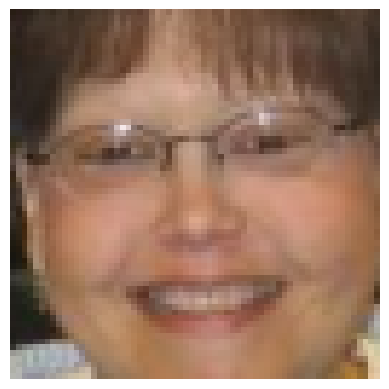

In [11]:
from PIL import Image
plt.axis('off')
plt.imshow(Image.fromarray(drop_na_image_data[0][0]), cmap='gray')

Split into Test and Train set

In [12]:
train, test = train_test_split(drop_na_image_data, test_size=0.20,random_state=11476)

In [13]:
print("Train: " + str(len(train)) + "\nTest: " + str(len(test)))

Train: 3921
Test: 981


Check distribution of smile, non-smile image between two set

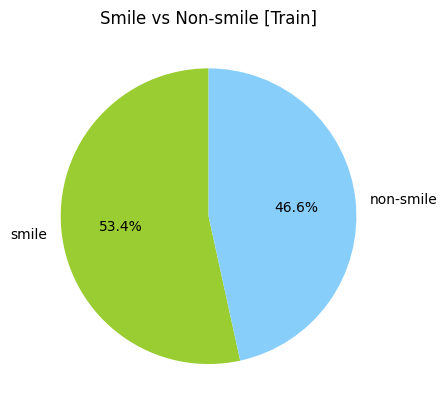

In [14]:
data = []
for i in train:
    if(i[1] == 1):
        data.append('smile')
    else:
        data.append('non-smile')

# Calculate the total count for each category
smile_count = data.count('smile')
non_smile_count = data.count('non-smile')
count_data = [smile_count, non_smile_count]

# Define the labels for the pie chart
labels = ['smile', 'non-smile']

# Define the colors for the pie chart
colors = ['yellowgreen', 'lightskyblue']

# Create the pie chart
plt.pie(count_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add the title to the plot
plt.title('Smile vs Non-smile [Train]')

# Show the plot
plt.show()

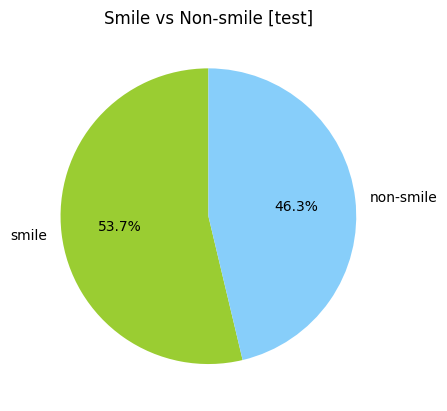

In [15]:
data = []
for i in test:
    if(i[1] == 1):
        data.append('smile')
    else:
        data.append('non-smile')

# Calculate the total count for each category
smile_count = data.count('smile')
non_smile_count = data.count('non-smile')
count_data = [smile_count, non_smile_count]

# Define the labels for the pie chart
labels = ['smile', 'non-smile']

# Define the colors for the pie chart
colors = ['yellowgreen', 'lightskyblue']

# Create the pie chart
plt.pie(count_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add the title to the plot
plt.title('Smile vs Non-smile [test]')

# Show the plot
plt.show()

In [16]:
train[2][0].shape

(64, 64, 3)

In [17]:
# Get shape of first numpy array
first_shape = train[0][0].shape

# Loop through remaining numpy arrays and check if their shape matches the first
for i in range(1, len(train)):
    if train[i][0].shape != first_shape:
        print(f"Array at index {i} has shape {train[i][0].shape}, which is different from the first array's shape of {first_shape}")

In [18]:
first_shape

(64, 64, 3)

Split the features and label

In [19]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [20]:
x_train[0].shape

(64, 64, 3)

In [21]:
x_val[0].shape

(64, 64, 3)

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Neural Network

In [23]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(64,64,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))

# two output
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

2023-04-18 05:20:48.040149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 05:20:48.040347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 05:20:48.040458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [24]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, start_from_epoch = 800, verbose = 1)
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [25]:
history = model.fit(x_train,y_train,epochs = 1200 , validation_data = (x_val, y_val), callbacks=[early_stopping])

Epoch 1/1200


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-04-18 05:20:55.463364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-18 05:20:56.475801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-18 05:20:57.415855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


123/123 [==============================] - 3s 5ms/step - loss: 0.6893 - accuracy: 0.5394 - val_loss: 0.6887 - val_accuracy: 0.5698
Epoch 2/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6887 - accuracy: 0.5409 - val_loss: 0.6872 - val_accuracy: 0.5443
Epoch 3/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5486 - val_loss: 0.6861 - val_accuracy: 0.5372
Epoch 4/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5435 - val_loss: 0.6851 - val_accuracy: 0.5392
Epoch 5/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.5476 - val_loss: 0.6842 - val_accuracy: 0.5372
Epoch 6/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6855 - accuracy: 0.5425 - val_loss: 0.6835 - val_accuracy: 0.5382
Epoch 7/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.5463 - val_loss: 0.6828 - val_accuracy: 0.5392
Epoch

123/123 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.6384 - val_loss: 0.6413 - val_accuracy: 0.6789
Epoch 58/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6520 - accuracy: 0.6373 - val_loss: 0.6405 - val_accuracy: 0.6799
Epoch 59/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6502 - accuracy: 0.6376 - val_loss: 0.6398 - val_accuracy: 0.6809
Epoch 60/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6517 - accuracy: 0.6348 - val_loss: 0.6390 - val_accuracy: 0.6830
Epoch 61/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.6409 - val_loss: 0.6382 - val_accuracy: 0.6830
Epoch 62/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6424 - val_loss: 0.6375 - val_accuracy: 0.6830
Epoch 63/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6506 - val_loss: 0.6367 - val_accuracy: 0.6830

123/123 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 0.6802 - val_loss: 0.5964 - val_accuracy: 0.7227
Epoch 114/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.6927 - val_loss: 0.5956 - val_accuracy: 0.7238
Epoch 115/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6108 - accuracy: 0.6838 - val_loss: 0.5947 - val_accuracy: 0.7207
Epoch 116/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.6822 - val_loss: 0.5939 - val_accuracy: 0.7238
Epoch 117/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.6871 - val_loss: 0.5931 - val_accuracy: 0.7258
Epoch 118/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6062 - accuracy: 0.6853 - val_loss: 0.5923 - val_accuracy: 0.7238
Epoch 119/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.6079 - accuracy: 0.6901 - val_loss: 0.5915 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.5693 - accuracy: 0.7309 - val_loss: 0.5482 - val_accuracy: 0.7584
Epoch 170/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.7230 - val_loss: 0.5471 - val_accuracy: 0.7686
Epoch 171/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5644 - accuracy: 0.7289 - val_loss: 0.5461 - val_accuracy: 0.7696
Epoch 172/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.7289 - val_loss: 0.5452 - val_accuracy: 0.7706
Epoch 173/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.7337 - val_loss: 0.5441 - val_accuracy: 0.7706
Epoch 174/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5632 - accuracy: 0.7294 - val_loss: 0.5432 - val_accuracy: 0.7696
Epoch 175/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.7365 - val_loss: 0.5423 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7743 - val_loss: 0.4933 - val_accuracy: 0.7992
Epoch 226/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5139 - accuracy: 0.7666 - val_loss: 0.4926 - val_accuracy: 0.8022
Epoch 227/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5180 - accuracy: 0.7733 - val_loss: 0.4915 - val_accuracy: 0.7992
Epoch 228/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5126 - accuracy: 0.7756 - val_loss: 0.4906 - val_accuracy: 0.8012
Epoch 229/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5170 - accuracy: 0.7728 - val_loss: 0.4897 - val_accuracy: 0.8022
Epoch 230/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5121 - accuracy: 0.7702 - val_loss: 0.4887 - val_accuracy: 0.8012
Epoch 231/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.7677 - val_loss: 0.4875 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.7853 - val_loss: 0.4418 - val_accuracy: 0.8287
Epoch 282/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.8090 - val_loss: 0.4409 - val_accuracy: 0.8287
Epoch 283/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.8064 - val_loss: 0.4401 - val_accuracy: 0.8287
Epoch 284/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.8095 - val_loss: 0.4391 - val_accuracy: 0.8298
Epoch 285/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8006 - val_loss: 0.4388 - val_accuracy: 0.8308
Epoch 286/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4652 - accuracy: 0.8046 - val_loss: 0.4374 - val_accuracy: 0.8308
Epoch 287/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.8062 - val_loss: 0.4367 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8291 - val_loss: 0.3970 - val_accuracy: 0.8451
Epoch 338/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.8258 - val_loss: 0.3961 - val_accuracy: 0.8461
Epoch 339/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4235 - accuracy: 0.8258 - val_loss: 0.3957 - val_accuracy: 0.8461
Epoch 340/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8296 - val_loss: 0.3947 - val_accuracy: 0.8491
Epoch 341/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8235 - val_loss: 0.3943 - val_accuracy: 0.8451
Epoch 342/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.8238 - val_loss: 0.3938 - val_accuracy: 0.8471
Epoch 343/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8330 - val_loss: 0.3927 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3873 - accuracy: 0.8472 - val_loss: 0.3628 - val_accuracy: 0.8614
Epoch 394/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8398 - val_loss: 0.3623 - val_accuracy: 0.8614
Epoch 395/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3885 - accuracy: 0.8419 - val_loss: 0.3619 - val_accuracy: 0.8583
Epoch 396/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.8528 - val_loss: 0.3614 - val_accuracy: 0.8593
Epoch 397/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.8447 - val_loss: 0.3611 - val_accuracy: 0.8603
Epoch 398/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3850 - accuracy: 0.8442 - val_loss: 0.3603 - val_accuracy: 0.8614
Epoch 399/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8434 - val_loss: 0.3597 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8579 - val_loss: 0.3382 - val_accuracy: 0.8685
Epoch 450/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8539 - val_loss: 0.3381 - val_accuracy: 0.8705
Epoch 451/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3636 - accuracy: 0.8528 - val_loss: 0.3375 - val_accuracy: 0.8685
Epoch 452/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8636 - val_loss: 0.3374 - val_accuracy: 0.8705
Epoch 453/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3593 - accuracy: 0.8556 - val_loss: 0.3367 - val_accuracy: 0.8685
Epoch 454/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.8551 - val_loss: 0.3365 - val_accuracy: 0.8685
Epoch 455/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8559 - val_loss: 0.3361 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8743 - val_loss: 0.3205 - val_accuracy: 0.8746
Epoch 506/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3393 - accuracy: 0.8625 - val_loss: 0.3204 - val_accuracy: 0.8756
Epoch 507/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3386 - accuracy: 0.8692 - val_loss: 0.3204 - val_accuracy: 0.8756
Epoch 508/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8572 - val_loss: 0.3197 - val_accuracy: 0.8756
Epoch 509/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8633 - val_loss: 0.3195 - val_accuracy: 0.8756
Epoch 510/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8620 - val_loss: 0.3192 - val_accuracy: 0.8746
Epoch 511/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8579 - val_loss: 0.3190 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3233 - accuracy: 0.8699 - val_loss: 0.3075 - val_accuracy: 0.8797
Epoch 562/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.8684 - val_loss: 0.3073 - val_accuracy: 0.8818
Epoch 563/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3257 - accuracy: 0.8694 - val_loss: 0.3069 - val_accuracy: 0.8818
Epoch 564/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3184 - accuracy: 0.8732 - val_loss: 0.3077 - val_accuracy: 0.8818
Epoch 565/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3217 - accuracy: 0.8761 - val_loss: 0.3064 - val_accuracy: 0.8828
Epoch 566/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3253 - accuracy: 0.8743 - val_loss: 0.3065 - val_accuracy: 0.8818
Epoch 567/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3212 - accuracy: 0.8722 - val_loss: 0.3069 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8789 - val_loss: 0.2974 - val_accuracy: 0.8818
Epoch 618/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8745 - val_loss: 0.2972 - val_accuracy: 0.8838
Epoch 619/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8794 - val_loss: 0.2969 - val_accuracy: 0.8848
Epoch 620/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.8789 - val_loss: 0.2970 - val_accuracy: 0.8818
Epoch 621/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8796 - val_loss: 0.2968 - val_accuracy: 0.8818
Epoch 622/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3069 - accuracy: 0.8766 - val_loss: 0.2966 - val_accuracy: 0.8818
Epoch 623/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.3096 - accuracy: 0.8789 - val_loss: 0.2962 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.3003 - accuracy: 0.8789 - val_loss: 0.2893 - val_accuracy: 0.8858
Epoch 674/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2989 - accuracy: 0.8842 - val_loss: 0.2891 - val_accuracy: 0.8879
Epoch 675/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2979 - accuracy: 0.8801 - val_loss: 0.2891 - val_accuracy: 0.8858
Epoch 676/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2968 - accuracy: 0.8842 - val_loss: 0.2892 - val_accuracy: 0.8869
Epoch 677/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8857 - val_loss: 0.2889 - val_accuracy: 0.8869
Epoch 678/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2938 - accuracy: 0.8845 - val_loss: 0.2890 - val_accuracy: 0.8869
Epoch 679/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2994 - accuracy: 0.8832 - val_loss: 0.2886 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2896 - accuracy: 0.8842 - val_loss: 0.2828 - val_accuracy: 0.8919
Epoch 730/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8860 - val_loss: 0.2826 - val_accuracy: 0.8919
Epoch 731/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2889 - accuracy: 0.8832 - val_loss: 0.2825 - val_accuracy: 0.8919
Epoch 732/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.8852 - val_loss: 0.2825 - val_accuracy: 0.8909
Epoch 733/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2852 - accuracy: 0.8891 - val_loss: 0.2822 - val_accuracy: 0.8930
Epoch 734/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.8898 - val_loss: 0.2824 - val_accuracy: 0.8919
Epoch 735/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.8868 - val_loss: 0.2823 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.8814 - val_loss: 0.2773 - val_accuracy: 0.8950
Epoch 786/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2817 - accuracy: 0.8896 - val_loss: 0.2773 - val_accuracy: 0.8930
Epoch 787/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2783 - accuracy: 0.8906 - val_loss: 0.2773 - val_accuracy: 0.8930
Epoch 788/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2816 - accuracy: 0.8929 - val_loss: 0.2768 - val_accuracy: 0.8950
Epoch 789/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.8860 - val_loss: 0.2767 - val_accuracy: 0.8940
Epoch 790/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.8896 - val_loss: 0.2767 - val_accuracy: 0.8950
Epoch 791/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2762 - accuracy: 0.8914 - val_loss: 0.2766 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8929 - val_loss: 0.2728 - val_accuracy: 0.8940
Epoch 842/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2733 - accuracy: 0.8947 - val_loss: 0.2726 - val_accuracy: 0.8940
Epoch 843/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2709 - accuracy: 0.8962 - val_loss: 0.2724 - val_accuracy: 0.8960
Epoch 844/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.8954 - val_loss: 0.2724 - val_accuracy: 0.8950
Epoch 845/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2732 - accuracy: 0.8921 - val_loss: 0.2726 - val_accuracy: 0.8930
Epoch 846/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2719 - accuracy: 0.8954 - val_loss: 0.2728 - val_accuracy: 0.8930
Epoch 847/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.8934 - val_loss: 0.2721 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2729 - accuracy: 0.8903 - val_loss: 0.2690 - val_accuracy: 0.8950
Epoch 898/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.8980 - val_loss: 0.2696 - val_accuracy: 0.8940
Epoch 899/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2665 - accuracy: 0.8924 - val_loss: 0.2694 - val_accuracy: 0.8940
Epoch 900/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2641 - accuracy: 0.8970 - val_loss: 0.2688 - val_accuracy: 0.8950
Epoch 901/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.8954 - val_loss: 0.2685 - val_accuracy: 0.8981
Epoch 902/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2653 - accuracy: 0.8990 - val_loss: 0.2687 - val_accuracy: 0.8950
Epoch 903/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2628 - accuracy: 0.8952 - val_loss: 0.2690 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.9023 - val_loss: 0.2651 - val_accuracy: 0.8991
Epoch 954/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2567 - accuracy: 0.8993 - val_loss: 0.2653 - val_accuracy: 0.8950
Epoch 955/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.8949 - val_loss: 0.2650 - val_accuracy: 0.8991
Epoch 956/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.8980 - val_loss: 0.2656 - val_accuracy: 0.8950
Epoch 957/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2599 - accuracy: 0.9018 - val_loss: 0.2651 - val_accuracy: 0.8950
Epoch 958/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.8944 - val_loss: 0.2652 - val_accuracy: 0.8950
Epoch 959/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.9000 - val_loss: 0.2649 - val_accuracy: 

123/123 [==============================] - 0s 2ms/step - loss: 0.2527 - accuracy: 0.9046 - val_loss: 0.2626 - val_accuracy: 0.8970
Epoch 1010/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2544 - accuracy: 0.9021 - val_loss: 0.2623 - val_accuracy: 0.9001
Epoch 1011/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2506 - accuracy: 0.8998 - val_loss: 0.2622 - val_accuracy: 0.9001
Epoch 1012/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9000 - val_loss: 0.2623 - val_accuracy: 0.8970
Epoch 1013/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2556 - accuracy: 0.8957 - val_loss: 0.2621 - val_accuracy: 0.9001
Epoch 1014/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.8993 - val_loss: 0.2620 - val_accuracy: 0.9011
Epoch 1015/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2517 - accuracy: 0.9016 - val_loss: 0.2619 - val_accu

Epoch 1065/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2470 - accuracy: 0.9018 - val_loss: 0.2594 - val_accuracy: 0.9011
Epoch 1066/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.8988 - val_loss: 0.2596 - val_accuracy: 0.9001
Epoch 1067/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.9028 - val_loss: 0.2594 - val_accuracy: 0.9011
Epoch 1068/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9059 - val_loss: 0.2595 - val_accuracy: 0.9021
Epoch 1069/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.9031 - val_loss: 0.2593 - val_accuracy: 0.9021
Epoch 1070/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9049 - val_loss: 0.2594 - val_accuracy: 0.9021
Epoch 1071/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2417 - accuracy: 0.9036 - val_loss: 0

Epoch 1121/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9016 - val_loss: 0.2567 - val_accuracy: 0.9032
Epoch 1122/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2432 - accuracy: 0.9021 - val_loss: 0.2567 - val_accuracy: 0.9052
Epoch 1123/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2400 - accuracy: 0.9069 - val_loss: 0.2567 - val_accuracy: 0.9032
Epoch 1124/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2418 - accuracy: 0.9005 - val_loss: 0.2564 - val_accuracy: 0.9052
Epoch 1125/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9056 - val_loss: 0.2564 - val_accuracy: 0.9032
Epoch 1126/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.9046 - val_loss: 0.2566 - val_accuracy: 0.9052
Epoch 1127/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.9072 - val_loss: 0

Epoch 1177/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.9051 - val_loss: 0.2546 - val_accuracy: 0.9042
Epoch 1178/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2376 - accuracy: 0.9028 - val_loss: 0.2544 - val_accuracy: 0.9083
Epoch 1179/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.9049 - val_loss: 0.2544 - val_accuracy: 0.9052
Epoch 1180/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2336 - accuracy: 0.9090 - val_loss: 0.2545 - val_accuracy: 0.9042
Epoch 1181/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9051 - val_loss: 0.2543 - val_accuracy: 0.9072
Epoch 1182/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2335 - accuracy: 0.9087 - val_loss: 0.2547 - val_accuracy: 0.9052
Epoch 1183/1200
123/123 [==============================] - 0s 2ms/step - loss: 0.2373 - accuracy: 0.9056 - val_loss: 0

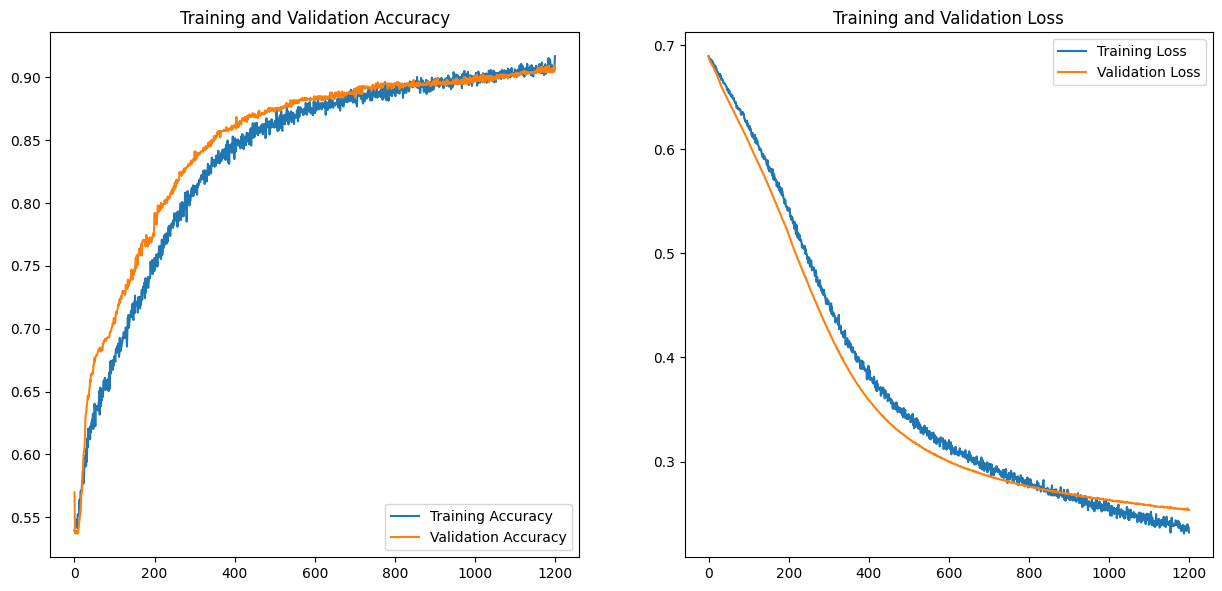

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1200)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
predictions = model.predict(x_val,steps=1,use_multiprocessing=True)
#predictions = predictions.reshape(1,-1)[0]
pred_y=np.argmax(predictions,axis=1)
print(classification_report(y_val, pred_y, target_names = ['Non-Smile (Class 0)','Smile (Class 1)']))

1/1 [==============================] - 0s 201ms/step
                     precision    recall  f1-score   support

Non-Smile (Class 0)       0.90      0.91      0.90       454
    Smile (Class 1)       0.92      0.91      0.92       527

           accuracy                           0.91       981
          macro avg       0.91      0.91      0.91       981
       weighted avg       0.91      0.91      0.91       981



Test Model

In [28]:
# Asian
img_asian = cv2.imread('/tf/smile_asian.jpg')[...,::-1]
# Malay
img_malay = cv2.imread('/tf/smile_malay.jpg')[...,::-1]

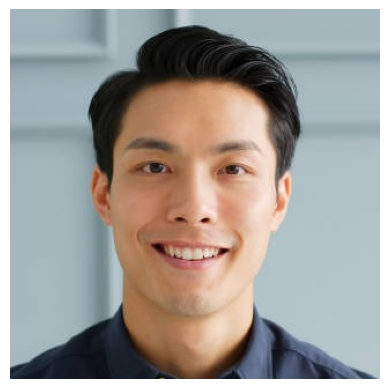

In [29]:
plt.axis('off')
plt.imshow(img_asian)

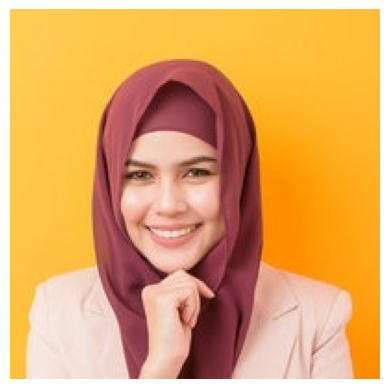

In [30]:
plt.axis('off')
plt.imshow(img_malay)

In [31]:
# Test Asian
img_asian_crop = crop_face(img_asian)
img_asian_crop = np.expand_dims(img_asian_crop, 0)
pred_y = np.argmax(model.predict(img_asian_crop,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 87ms/step


array([1])

In [32]:
# Test Malay
img_malay_reshape = cv2.resize(img_malay, (img_size, img_size))
img_malay_reshape = np.expand_dims(img_malay_reshape, 0)
pred_y = np.argmax(model.predict(img_malay_reshape,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 11ms/step


array([1])

In [33]:
# saving and loading the .h5 model
 
# save model
model.save('smile_model_GENKI4K.h5')
print('Model Saved!')

Model Saved!


In [34]:
# load model
savedModel=load_model('smile_model_GENKI4K.h5')
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [35]:
# Test Asian
img_asian_crop = crop_face(img_asian)
img_asian_crop = np.expand_dims(img_asian_crop, 0)
pred_y = np.argmax(savedModel.predict(img_asian_crop,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 35ms/step


array([1])

In [36]:
# Test Malay
img_malay_crop = crop_face(img_malay)
img_malay_crop = np.expand_dims(img_malay_crop, 0)
pred_y = np.argmax(savedModel.predict(img_malay_crop,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 10ms/step


array([1])

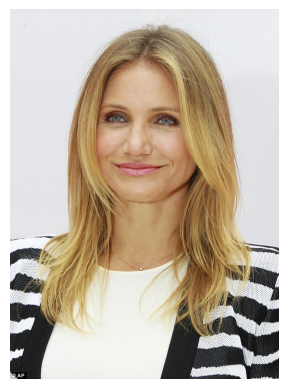

In [37]:
# Test smile without teeth
img_smile_no_teeth = cv2.imread('/tf/210B9D2E00000578-4647718-image-a-5_1498670515946.jpg')[...,::-1]
plt.axis('off')
plt.imshow(img_smile_no_teeth)

In [38]:
# Test Smile No Teeth
img_smile_no_teeth = crop_face(img_smile_no_teeth)
img_smile_no_teeth = np.expand_dims(img_smile_no_teeth, 0)
pred_y = np.argmax(savedModel.predict(img_smile_no_teeth,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 9ms/step


array([0])

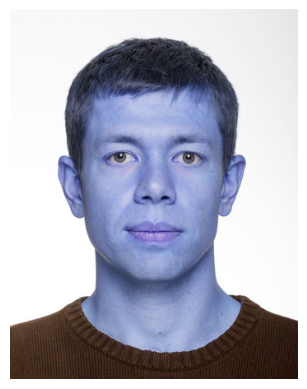

In [45]:
# Test Neutral face
# Test smile without teeth
neutral = cv2.imread('/tf/57053528-man-head-shot-with-neutral-face-expression-and-white-background.jpg')
plt.axis('off')
plt.imshow(neutral)

In [40]:
# Test Neutral
neutral = crop_face(neutral)
neutral = np.expand_dims(neutral, 0)
pred_y = np.argmax(savedModel.predict(neutral,steps=1,use_multiprocessing=True),axis=1)
pred_y

1/1 [==============================] - 0s 10ms/step


array([0])

In [56]:
predict_smile(neutral)

0

In [42]:
# load model
savedModel=load_model('smile_model_GENKI4K.h5')
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [43]:
def predict_smile(frame):
    if np.shape(frame) == ():
        predicted_label = [0]
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = crop_face(frame)
        frame = np.expand_dims(frame, 0)
        predicted_label = np.argmax(savedModel.predict(frame,steps=1,use_multiprocessing=True,verbose=0),axis=1)
    return predicted_label[0]

In [64]:
def predict_smile_2(frame):
    if np.shape(frame) == ():
        predicted_label = [0]
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = crop_face(frame)
        frame = np.expand_dims(frame, 0)
        predicted_label = np.argmax(savedModel.predict(frame,steps=1,use_multiprocessing=True,verbose=0),axis=1)
    return predicted_label[0]

In [66]:
predict_smile_2(neutral)

0

In [68]:
# video
cap = cv2.VideoCapture("smile.mp4")

# webcam
#cap = cv2.VideoCapture(0)


# Put the code in try-except statements
# Catch the keyboard exception and 
# release the camera device and 
# continue with the rest of code.
SMILE_THERESHOLD = 3

smile_result = 0
smile_delay = 0
try:
    # Check if the webcam is opened correctly
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    
    while(True):
        ret, frame = cap.read()

        if not ret:
            print("Released Video Resource")
            break
        
        result = predict_smile(frame)
        ## Delay function (to keep the detected smile for while)
        ### Codes for showing frame
        # Turn off the axis
        plt.axis('off')
        # Title of the window
        plt.title(result)
        if result == 1:
            cv2.imwrite('captured.jpg',frame)
        # Display the frame
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        # Display the frame until new frame is available
        # Overwrite the old graph
        clear_output(wait=True)
            
        '''
        ### Codes for showing frame
        # Turn off the axis
        plt.axis('off')
        # Title of the window
        plt.title(smile_result)
        # Display the frame
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        # Display the frame until new frame is available
        # Overwrite the old graph
        clear_output(wait=True)
        '''

# If stop button are clicked
except KeyboardInterrupt:
    # Release the Video Device
    cap.release()
    # Message to be displayed after releasing the device
    print("Released Video Resource")

Released Video Resource
